In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
directory = '../data/'
output_dir = '../data/csv_grouped_data'

In [3]:
filename_ibex ="../data/grouped_data_day_mean_full_tweets_sentiment_ngrams_ibex35.csv"
filename_ibex_prices ="../data/bolsas_ibex_2010-2021.csv"
filename_precios_bolsa = "../data/bolsa_mad_2010-2021.csv"
filename_asoc = "../data/grouped_data_day_mean_full_tweets_sentiment_ngrams_asociaciones_empresariales.csv"

df_asoc = pd.read_csv(filename_asoc, sep=";")
df_ibex = pd.read_csv(filename_ibex, sep=";")
df_ibex_prices = pd.read_csv(filename_ibex_prices, sep=";")
df_precios_bolsa = pd.read_csv(filename_precios_bolsa, sep=";")

df_asoc['normalised_date'] = pd.to_datetime(df_asoc['normalised_date'], errors='coerce')
df_asoc['normalised_date'] = df_asoc['normalised_date'].dt.normalize()
df_ibex['normalised_date'] = pd.to_datetime(df_ibex['normalised_date'], errors='coerce')
df_ibex['normalised_date'] = df_ibex['normalised_date'].dt.normalize()


df_ibex_prices['Dates'] = pd.to_datetime(df_ibex_prices['Dates'], errors='coerce')
df_ibex_prices['Dates'] = df_ibex_prices['Dates'].dt.normalize()

df_precios_bolsa['Dates'] = pd.to_datetime(df_precios_bolsa['Dates'], errors='coerce')
df_precios_bolsa['Dates'] = df_precios_bolsa['Dates'].dt.normalize()

df_ibex_prices.rename(columns = {'LAST_PRICE':'Close', 'Dates': 'Date'}, inplace = True)


In [9]:
df_x = pd.merge(left=df_asoc, right=df_ibex, left_on='normalised_date', right_on='normalised_date')
df_total = pd.merge(left=df_x, right=df_ibex_prices, left_on='normalised_date', right_on='Date')
df_total = df_total.rename(columns={"sentiment_x": "sentiment_asociacones", "sentiment_y": "sentiment_ibex"})
df_total["normalised_date"]= pd.to_datetime(df_total["normalised_date"]) 
df_total = df_total[["normalised_date","sentiment_asociacones", "sentiment_ibex", "Close"]]
df_total

,normalised_date,sentiment_asociacones,sentiment_ibex,Close
0,2010-01-04,0.180934,0.163938,12145.1
1,2010-01-05,0.083857,0.206305,12204.4
2,2010-01-07,0.416657,0.188553,12166.3
3,2010-01-08,0.026698,0.192648,12163.0
4,2010-01-12,0.015352,0.307515,11966.1
...,...,...,...,...
2848,2020-12-28,0.252183,0.104485,8155.6
2849,2020-12-29,0.238587,0.138290,8174.8
2850,2020-12-30,0.223283,0.116739,8154.4
2851,2020-12-31,0.354437,0.102232,8073.7


In [10]:
df_total.sentiment_asociacones = df_total.sentiment_asociacones
df_total.sentiment_ibex = df_total.sentiment_ibex
df_total.Close = df_total.Close.diff()

df_total = df_total.rename(columns={"Close": "madrid_change"})
df_total['sentiment_asociacones'] = df_total['sentiment_asociacones'].astype(float).diff()
df_total['sentiment_ibex'] = df_total['sentiment_ibex'].astype(float).diff()
df_total['madrid_change'] = df_total['madrid_change'].astype(float)


In [11]:
df_total = df_total.dropna()
df_total = df_total[['normalised_date','sentiment_asociacones', 'sentiment_ibex', 'madrid_change']]
df_total.to_csv("df_total_es_ngrams.csv", sep=";")

df_total_no_covid = df_total.copy()
df_total_no_covid = df_total_no_covid[:-100]
df_total_no_covid



,normalised_date,sentiment_asociacones,sentiment_ibex,madrid_change
1,2010-01-05,-0.097076,0.042367,59.3
2,2010-01-07,0.332799,-0.017752,-38.1
3,2010-01-08,-0.389959,0.004095,-3.3
4,2010-01-12,-0.011345,0.114867,-196.9
5,2010-01-14,0.259258,-0.124711,33.7
...,...,...,...,...
2748,2020-08-10,0.015207,0.002624,103.4
2749,2020-08-11,0.073991,-0.014380,209.6
2750,2020-08-12,-0.067574,-0.015768,32.5
2751,2020-08-13,-0.072786,0.049261,-45.5


In [17]:
from statsmodels.tsa.stattools import grangercausalitytests

start_date = "2020-05-10 00:00:00.000"
end_date = "2020-12-01 00:00:00.000"

mask = (df_total['normalised_date'] > start_date) & (df_total['normalised_date'] <= end_date)
df_restricted = df_total.copy()
df_restricted = df_restricted.loc[mask]
print(df_restricted[['sentiment_ibex','madrid_change']])


granger_test = sm.tsa.stattools.grangercausalitytests(df_total[['sentiment_ibex','madrid_change']], maxlag=30,  verbose=True)
granger_test


      sentiment_ibex  madrid_change
2683        0.027097         -110.9
2684       -0.020043           90.5
2685        0.008944         -131.3
2686        0.020091          -85.8
2687       -0.003446          -70.7
...              ...            ...
2825        0.029095           21.5
2826       -0.041002          -60.1
2827        0.054591           86.1
2828       -0.032043         -113.8
2829        0.011551           63.9

[147 rows x 2 columns]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5498  , p=0.4585  , df_denom=2848, df_num=1
ssr based chi2 test:   chi2=0.5504  , p=0.4582  , df=1
likelihood ratio test: chi2=0.5503  , p=0.4582  , df=1
parameter F test:         F=0.5498  , p=0.4585  , df_denom=2848, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0398  , p=0.9610  , df_denom=2845, df_num=2
ssr based chi2 test:   chi2=0.0798  , p=0.9609  , df=2
likelihood ratio test: chi2=0.0798  , p=0.9609  , df=2
parameter 

{1: ({'ssr_ftest': (0.549820812804687, 0.4584520569716387, 2848.0, 1),
   'ssr_chi2test': (0.5503999779867144, 0.458154309401812, 1),
   'lrtest': (0.5503468560709734, 0.4581760035699094, 1),
   'params_ftest': (0.5498208128060197, 0.45845205697112135, 2848.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.03980621586898974, 0.9609761781496844, 2845.0, 2),
   'ssr_chi2test': (0.07975234813822198, 0.9609084171651442, 2),
   'lrtest': (0.07975123229334713, 0.9609089532776599, 2),
   'params_ftest': (0.03980621586390373, 0.9609761781546928, 2845.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.413530743704349, 0.7432985264896181, 2842.0, 3),
   'ssr_chi2test': (1.2436478770024881, 0.7425558935110397, 3),
   'lrtest': (1.2433765168607351, 0.7426207205081541, 3),
   'params_ftest': (0.41353074370797716, 0.743298526486978, 2842.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

In [13]:
from statsmodels.tsa.stattools import grangercausalitytests

start_date = "2020-01-10 00:00:00.000"
end_date = "2020-05-01 00:00:00.000"

mask = (df_total['normalised_date'] > start_date) & (df_total['normalised_date'] <= end_date)
df_restricted = df_total.copy()
df_restricted = df_restricted.loc[mask]
print(df_restricted)


granger_test = sm.tsa.stattools.grangercausalitytests(df_total[['sentiment_asociacones','madrid_change']], maxlag=20, verbose=True)
granger_test
#SIGNIFICATIVE LAGS 1, 2, 3, 4

     normalised_date  sentiment_asociacones  sentiment_ibex  madrid_change
2598      2020-01-13               0.154907       -0.007590          -29.7
2599      2020-01-14              -0.037317       -0.062687          -15.6
2600      2020-01-15              -0.059082        0.063971          -16.6
2601      2020-01-16              -0.049738        0.023267           60.8
2602      2020-01-17               0.027810       -0.040012          108.8
...              ...                    ...             ...            ...
2673      2020-04-27              -0.078744       -0.010174          117.9
2674      2020-04-28              -0.017852        0.013892          104.6
2675      2020-04-29               0.023493       -0.007661          219.3
2676      2020-04-30              -0.008973        0.035951         -133.4
2677      2020-05-01              -0.083297       -0.006826            0.0

[80 rows x 4 columns]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.8

'\nGranger Causality\nnumber of lags (no zero) 1\nssr based F test:         F=2.8171  , p=0.0934  , df_denom=2848, df_num=1\nssr based chi2 test:   chi2=2.8201  , p=0.0931  , df=1\nlikelihood ratio test: chi2=2.8187  , p=0.0932  , df=1\nparameter F test:         F=2.8171  , p=0.0934  , df_denom=2848, df_num=1\n'

In [18]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Fit the model
model = VAR(df_total[['sentiment_asociacones', 'sentiment_ibex', 'madrid_change']])
results = model.fit(maxlags=15, ic='aic')

# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Fit the model
model_restricted = VAR(df_total_no_covid[['sentiment_asociacones', 'sentiment_ibex', 'madrid_change']])
results_restricted = model.fit(maxlags=15, ic='aic')
results.summary()
results_restricted.summary()

/Users/hugojose/.local/share/virtualenvs/twitter-data-scripts-analysis-uDKChz6k/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/hugojose/.local/share/virtualenvs/twitter-data-scripts-analysis-uDKChz6k/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Feb, 2021
Time:                     20:37:12
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.00420
Nobs:                     2837.00    HQIC:                  -2.18924
Log likelihood:          -8685.04    FPE:                   0.100898
AIC:                     -2.29365    Det(Omega_mle):       0.0961451
--------------------------------------------------------------------
Results for equation sentiment_asociacones
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.000179         0.001329           -0.135           0.893
L1.sentiment_asociacones         -0.876018         0.019006          -46.091           0.

In [19]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Fit the model
model_no_covid = VAR(df_total_no_covid[['sentiment_asociacones', 'sentiment_ibex', 'madrid_change']])
results_no_covid = model_no_covid.fit(maxlags=15, ic='aic')
results_no_covid.summary()

/Users/hugojose/.local/share/virtualenvs/twitter-data-scripts-analysis-uDKChz6k/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Feb, 2021
Time:                     20:37:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.95865
Nobs:                     2737.00    HQIC:                  -2.14910
Log likelihood:          -8424.38    FPE:                   0.104679
AIC:                     -2.25686    Det(Omega_mle):       0.0995738
--------------------------------------------------------------------
Results for equation sentiment_asociacones
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.000329         0.001359           -0.242           0.809
L1.sentiment_asociacones         -0.878737         0.019282          -45.573           0.

In [20]:

# convert to (records, timesteps, indicators)
def create_window_data_arrays(arrays,window_size):
    data = np.column_stack((arrays))
    arr_len = len(arrays[0])
    windows = np.array([data[i-window_size: i] for i in range(window_size +1,arr_len+1)])
    return windows


def create_window_data_array_with_shift(array,window_size, shift):
    return np.array([array[i-window_size: i] for i in range(shift +1,len(array)+1)])

In [21]:
lag_order = results.k_ar
print(df_total_no_covid)
train_x = create_window_data_arrays((df_total_no_covid.sentiment_asociacones,df_total_no_covid.sentiment_ibex, df_total_no_covid.madrid_change), lag_order)
print(train_x.shape)
print(train_x[-1])
print("----")

print(df_total_no_covid.values[-1])
print("----")
print(results.forecast(train_x[-1], 1))


     normalised_date  sentiment_asociacones  sentiment_ibex  madrid_change
1         2010-01-05              -0.097076        0.042367           59.3
2         2010-01-07               0.332799       -0.017752          -38.1
3         2010-01-08              -0.389959        0.004095           -3.3
4         2010-01-12              -0.011345        0.114867         -196.9
5         2010-01-14               0.259258       -0.124711           33.7
...              ...                    ...             ...            ...
2748      2020-08-10               0.015207        0.002624          103.4
2749      2020-08-11               0.073991       -0.014380          209.6
2750      2020-08-12              -0.067574       -0.015768           32.5
2751      2020-08-13              -0.072786        0.049261          -45.5
2752      2020-08-14               0.117330       -0.028102          -96.2

[2752 rows x 4 columns]
(2737, 15, 3)
[[-2.09582613e-02 -2.19285040e-02 -1.24100000e+02]
 [ 8.44038

In [22]:
lag_order_restricted = results_restricted.k_ar
train_x_restricted = create_window_data_arrays((df_restricted.sentiment_asociacones,df_restricted.sentiment_ibex, df_restricted.madrid_change), lag_order_restricted)


In [23]:
results.forecast(train_x[0], 1)
forecasted = np.array([list(results.forecast(train_x[i], 1)[0]) for i in range(0,train_x.shape[0])])
print(forecasted[-1])

print(df_total.values.shape)
print(forecasted.shape)

# while using one ts
#y_pred = forecasted[:,1:]
y_pred = forecasted[:,2:]
y_train = df_total_no_covid.madrid_change.values[lag_order:]

M = np.column_stack((y_train, y_pred))

from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(forecasted, y_pred))


print(M)
plt.plot(M[-200:])

[-5.26588636e-03  3.10627422e-03 -1.70682669e+01]
(2852, 4)
(2737, 3)


ValueError: y_true and y_pred have different number of output (3!=1)

85.15350605606892
[[ 1.24900000e+02  1.88846842e+00]
 [ 1.86700000e+02  4.58492297e+00]
 [ 2.18300000e+02  1.57465016e+01]
 [-5.96000000e+01  7.42277892e+00]
 [ 3.05800000e+02  1.75228673e+00]
 [ 2.35000000e+01 -3.46127411e+01]
 [-1.43800000e+02 -6.44262734e+00]
 [-8.84000000e+01 -7.36899199e+00]
 [-3.85900000e+02 -2.05275058e+00]
 [ 1.47000000e+01 -6.51363298e+00]
 [-3.34000000e+01  2.27973208e+01]
 [ 2.36000000e+02  6.62633812e+00]
 [-1.66000000e+01 -1.44458312e+01]
 [-8.85000000e+01  8.18361533e+00]
 [ 2.40000000e+01 -1.09711298e+01]
 [-6.85000000e+01  1.12420488e+01]
 [ 9.27000000e+01 -1.84786575e+01]
 [-2.42900000e+02  3.21431912e+01]
 [ 7.48000000e+01 -7.58086091e+00]
 [-9.19000000e+01  1.87528688e+00]
 [ 9.97000000e+01  3.11267869e+01]
 [-4.67000000e+01 -1.75882378e+01]
 [-4.00000000e+00  3.13016484e+00]
 [ 2.71200000e+02 -4.71132750e+00]
 [-9.51000000e+01  2.53873924e+01]
 [ 1.52700000e+02 -4.72070851e+00]
 [-1.08800000e+02 -2.62857072e+00]
 [-1.21000000e+02 -1.55279767e+01]
 [

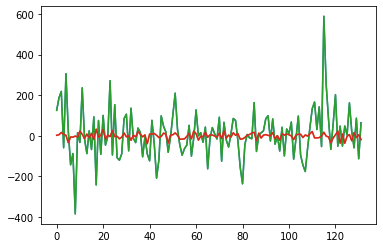

In [24]:
results_restricted.forecast(train_x[0], 1)
forecasted = np.array([list(results_restricted.forecast(train_x_restricted[i], 1)[0]) for i in range(0,train_x_restricted.shape[0])])

y_pred = forecasted[:,2:]
y_train = df_restricted.madrid_change.values[lag_order_restricted:]

M = np.column_stack((y_train, y_pred))

from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_train, y_pred))


print(M)
plt.plot(M[-200:])
print(M)
plt.plot(M[-200:])

In [25]:
# Split data
nobs = 4
df_train, df_test = df_total[0:-nobs], df_total[-nobs:]
# Check for stationarity with Augmented Dickey-Fuller Test (ADF Test)
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller

def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

#apply adf test on the series
adf_test(df_train["sentiment_asociacones"])
adf_test(df_train["sentiment_ibex"])
adf_test(df_train["madrid_change"])

Test Statistic         -1.574850e+01
p-value                 1.231430e-28
# Lags                  2.800000e+01
# Observations          2.819000e+03
Critical Value (1%)    -3.432672e+00
Critical Value (5%)    -2.862566e+00
Critical Value (10%)   -2.567316e+00
dtype: float64
 Series is Stationary
Test Statistic         -1.556871e+01
p-value                 1.999458e-28
# Lags                  2.400000e+01
# Observations          2.823000e+03
Critical Value (1%)    -3.432669e+00
Critical Value (5%)    -2.862564e+00
Critical Value (10%)   -2.567315e+00
dtype: float64
 Series is Stationary
Test Statistic           -19.319662
p-value                    0.000000
# Lags                     7.000000
# Observations          2840.000000
Critical Value (1%)       -3.432655
Critical Value (5%)       -2.862558
Critical Value (10%)      -2.567312
dtype: float64
 Series is Stationary
